# **SETUP**

1) continue Image Classification problem from previous class which aims to classify microscopy images into good, empty or blurred by: 
1. gathering ~1000 samples per class for training the model; 
2. using https://supervise.ly for image augmentation to generate more samples;
3. using CNN - AlexNet

2) denoise blurred images using auto-encoder
1. please see https://blog.keras.io/building-autoencoders-in-keras.html
2. Simple structure could be: blurry input images -> feed into CNN (this could be transfer learning) -> train x - noise image  y - clean image -> Fully connected NN -> reconstructed clean image

3) track patches from fluorescence images and use a visualization tool


In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import keras
from platform import python_version

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
keras.__version__

'2.2.5'

In [3]:
tf.__version__

'1.15.2'

In [4]:
print(python_version())

3.6.9


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras import applications
import tensorflow as tf
from tqdm import tqdm
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import random
from shutil import copyfile
import os
import gc
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras import backend as K

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import style
import seaborn as sns
from keras.callbacks import ModelCheckpoint
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
%cd /content/drive/My Drive/DeepLearning/Project/dataset1

!ls

/content/drive/My Drive/DeepLearning/Project/dataset1
blurred  good	     modelAlexNet_1.h5	modelAlexNet_3.h5  test
empty	 model_1.h5  modelAlexNet_2.h5	modelAlexNet_4.h5  train


# **Data Preparation**

In [0]:
X=[]
y=[]
IMG_SIZE=224
GOOD_DIR='good'
EMPTY_DIR='empty'
BLURRED_DIR='blurred'

def assigning_label(img,image_type):
    return image_type

def make_train_data(image_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assigning_label(img,image_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        y.append(str(label))

In [10]:
#create training data
make_train_data('good',GOOD_DIR)
make_train_data('empty',EMPTY_DIR)
make_train_data('blurred',BLURRED_DIR)
print(len(X))

100%|██████████| 3072/3072 [12:51<00:00,  3.98it/s]

7032


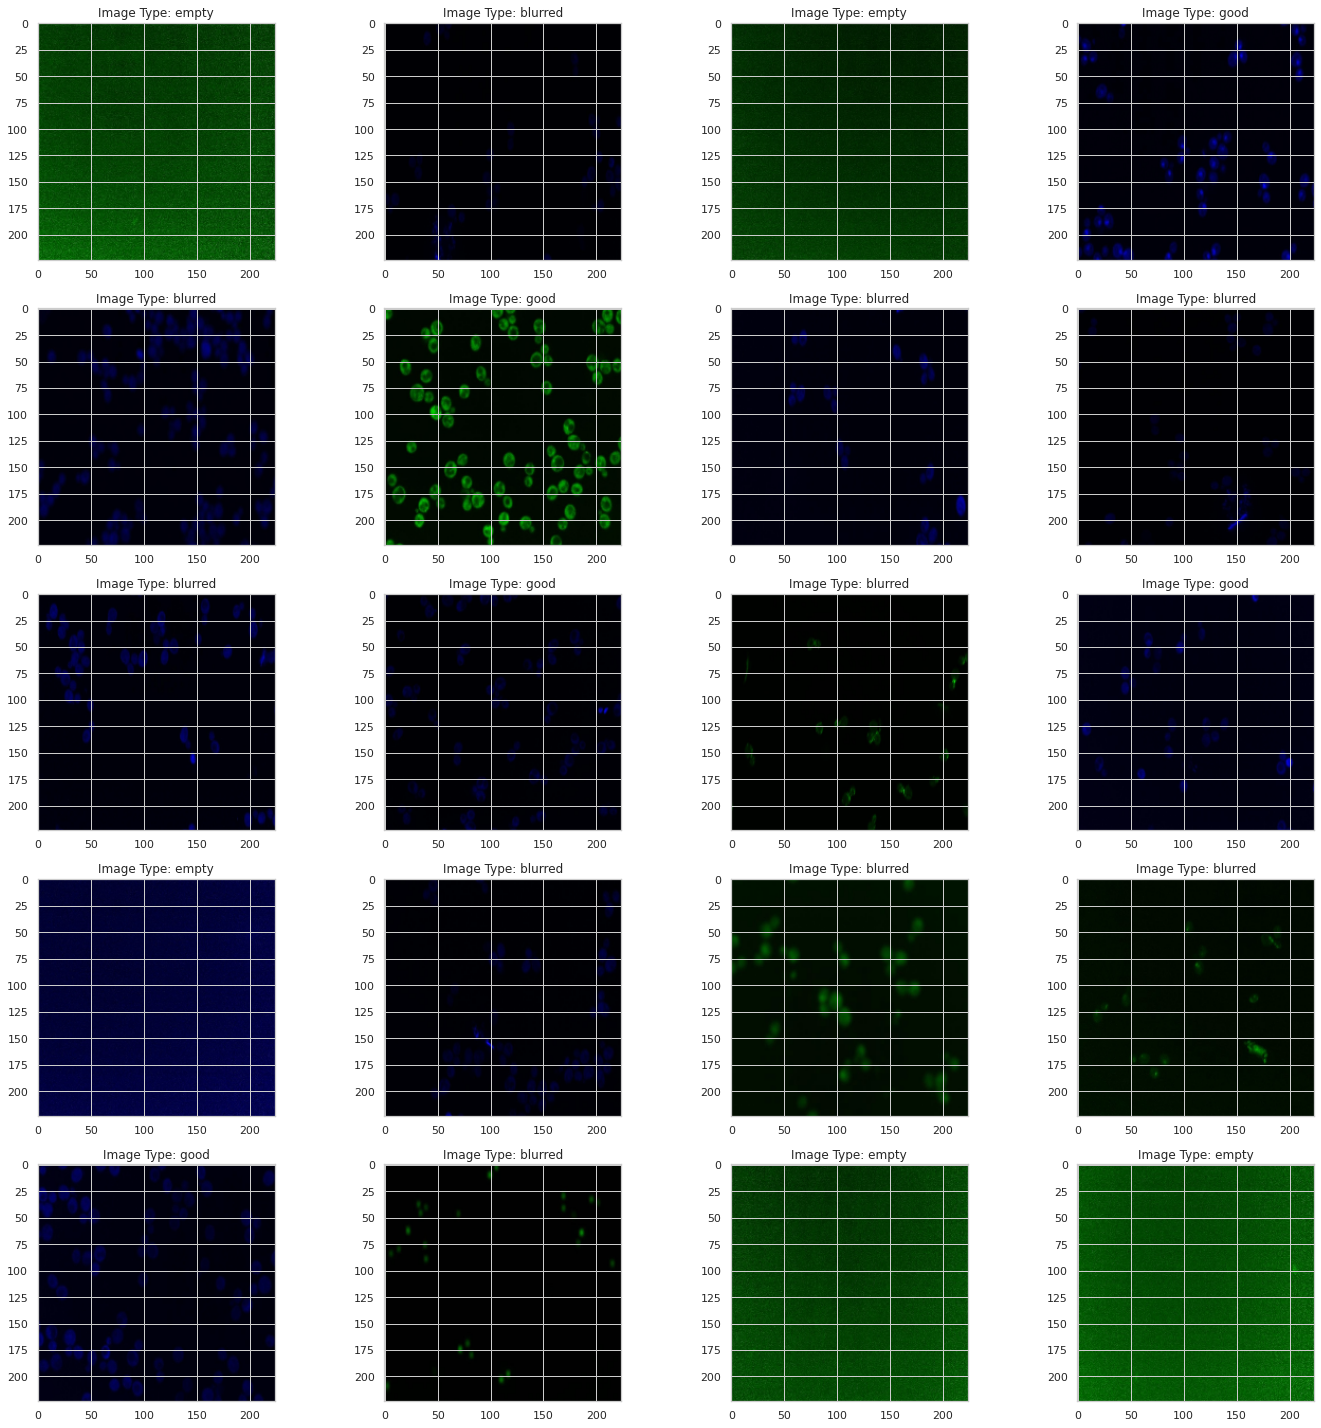

In [12]:
import random as rn
fig,ax=plt.subplots(5,4)
fig.set_size_inches(20,20)
for i in range(5):
    for j in range (4):
        l=rn.randint(0,len(y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Image Type: '+y[l])
        
plt.tight_layout()

In [0]:
from sklearn.preprocessing import LabelEncoder

labelEncoder=LabelEncoder()
y=labelEncoder.fit_transform(y)
y=to_categorical(y,3)
X=np.array(X)
X=X/255

In [12]:
X.shape

(7032, 224, 224, 3)

In [13]:
y.shape

(7032, 3)

In [0]:
X_train_val,X_test,y_train_val,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train_val,y_train_val,test_size=0.25,random_state=42)

In [15]:
X_train.shape

(3955, 224, 224, 3)

In [16]:
y_train.shape

(3955, 3)

# **BASE MODEL AlexNet**

### AlexNet Architecture
Import AlexNet; adjust output shape to 3

In [21]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np
np.random.seed(1000)
#Instantiate an empty model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# Output Layer - changed output shape to 3
model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

# Compile the model

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_2 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         


### Early Stopping

In [0]:
es = EarlyStopping(monitor='val_acc', verbose=2, patience=25)
filepath = "./modelAlexNet_5.h5"
mc = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)

### Train Model

In [0]:
# learn_rate = [0.01]
# batch_size = [32,75]
# epochs = [5]

# param_grid = dict(batch_size=batch_size, epochs=epochs)
# randSearch_2 = GridSearchCV(estimator = model, param_grid=param_grid, cv=5)

In [23]:
#Couldn't do an hyperparameter tuning/model optimization due to RAM limitations in colab :/
new_grid_1 = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 16, epochs = 30, verbose=2, callbacks=[es,mc])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 3955 samples, validate on 1319 samples
Epoch 1/30





 - 27s - loss: 0.8080 - acc: 0.5312 - val_loss: 0.6121 - val_acc: 0.6384

Epoch 00001: val_acc improved from -inf to 0.63836, saving model to ./modelAlexNet_5.h5
Epoch 2/30
 - 24s - loss: 0.6121 - acc: 0.6187 - val_loss: 0.5826 - val_acc: 0.6452

Epoch 00002: val_acc improved from 0.63836 to 0.64519, saving model to ./modelAlexNet_5.h5
Epoch 3/30
 - 24s - loss: 0.5869 - acc: 0.6298 - val_loss: 0.5633 - val_acc: 0.6505

Epoch 00003: val_acc improved from 0.64519 to 0.65049, saving model to ./modelAlexNet_5.h5
Epoch 4/30
 - 25s - loss: 0.5641 - acc: 0.6498 - val_loss: 0.5554 - val_acc: 0.6634

Epoch 00004: val_acc improved from 0.65049 to 0.66338, saving model to ./modelAlexNet_5.h5
Epoch 5/30
 - 24s - loss: 0.5845 - acc: 0.6582 - val_loss: 0.5638 - val_acc: 0.6596

Epoch 00005: val_acc did not improve from 0.66338
Epoch 6/30
 - 

### Load saved model and Evaluate

In [24]:
from keras.models import load_model
import numpy
import os

%cd /content/drive/My Drive/DeepLearning/Project/dataset1

/content/drive/My Drive/DeepLearning/Project/dataset1


In [0]:
final_model_AlexNet = tf.keras.models.load_model('./modelAlexNet_5.h5')


In [26]:
# evaluate the model on validation set
val_scores = []
val_scores_1 = final_model_AlexNet.evaluate(X_val, y_val, verbose=0)
print("%s: %.2f%%" % (final_model_AlexNet.metrics_names[1], val_scores_1[1]*100))
val_scores.append(val_scores_1[1] * 100)

acc: 85.37%


In [27]:
# evaluate the model
finalscores = []
final_scores_1 = final_model_AlexNet.evaluate(X_test,y_test, verbose=0)
print("%s: %.2f%%" % (final_model_AlexNet.metrics_names[1], final_scores_1[1]*100))
finalscores.append(final_scores_1[1] * 100)

acc: 84.76%
